In [12]:
from wobbles.workflow.integrate_single_orbit import integrate_orbit
from wobbles.workflow.compute_distribution_function import compute_df
from wobbles.disc import Disc
from wobbles.potential_extension import PotentialExtension
from wobbles.distribution_function import DistributionFunction
import numpy as np

import galpy
from galpy import util
from galpy.potential import MovingObjectPotential
from galpy.potential import MWPotential2014
from galpy.potential import evaluatePotentials
from galpy.util.bovy_conversion import get_physical
from galpy.orbit import Orbit

import astropy.units as apu
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator

## First do the computation with wobbles

In [2]:
f = open('MW14pot_100', "rb")
potential_extension = pickle.load(f)
units = potential_extension.units
f.close()

# Initialize Sagitarrius orbit
t_orbit = -1.64 # Gyr
N_tsteps = 1200
time_Gyr = np.linspace(0., t_orbit, N_tsteps) * apu.Gyr 
orbit_init_sag = [283. * apu.deg, -30. * apu.deg, 26. * apu.kpc,
        -2.6 * apu.mas/apu.yr, -1.3 * apu.mas/apu.yr, 140. * apu.km/apu.s] # Initial conditions of the satellite
sag_orbit_phsical_off = integrate_orbit(orbit_init_sag, potential_extension.galactic_potential, time_Gyr)
satellite_orbit_list = [sag_orbit_phsical_off]

# endow satellite with mass
satellite_potential_1 = galpy.potential.HernquistPotential(amp=2.*1e10*apu.M_sun,a= 3.*apu.kpc) 
satellite_potential_2 = galpy.potential.HernquistPotential(amp=2.*0.2e9*apu.M_sun,a=0.65*apu.kpc) 
satellite_potential = satellite_potential_1 + satellite_potential_2
galpy.potential.turn_physical_off(satellite_potential)
satellite_potential_list = [satellite_potential]

# Initialize the main class
disc = Disc(potential_extension, potential_extension)
time_internal_units = sag_orbit_phsical_off.time()
velocity_dispersion = [20.5]
normalization = [1.]

distribution_function, delta_J, force = compute_df(disc, time_internal_units,
                          satellite_orbit_list, satellite_potential_list, velocity_dispersion, normalization, 
                                                   verbose=False)

satellite_potential_list[0][0] *= 0.
satellite_potential_list[0][1] *= 0.
distribution_function_no_perturbation, _, _ = compute_df(disc, time_internal_units,
                          satellite_orbit_list, satellite_potential_list, velocity_dispersion, normalization, 
                                                     verbose=False)

## Plot results

Text(0,0.5,'$\\langle v_z^2 \\rangle$')

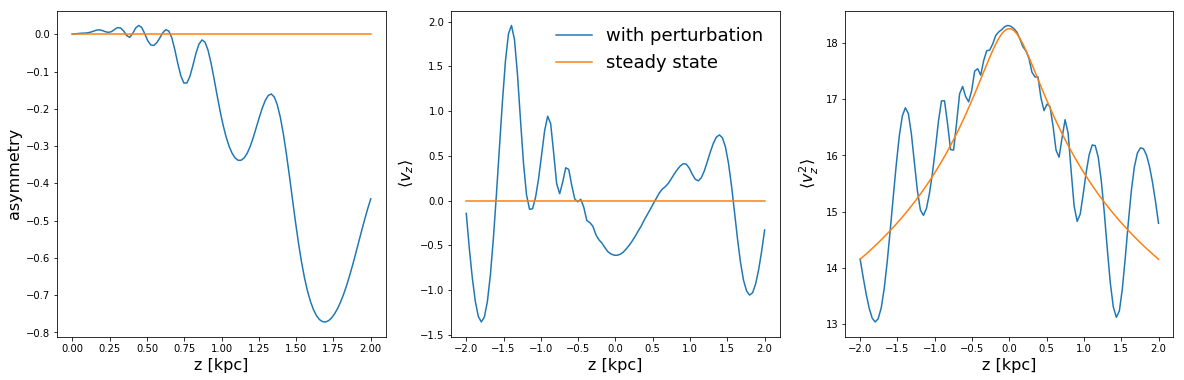

In [3]:
fig = plt.figure(1)
fig.set_size_inches(20, 6)
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

_z = np.linspace(0, 2, len(distribution_function.A))
ax1.plot(_z, distribution_function.A)
ax1.plot(_z, distribution_function_no_perturbation.A)
ax1.set_xlabel('z [kpc]', fontsize=16)
ax1.set_ylabel('asymmetry', fontsize=16)

_z = np.linspace(-2, 2, len(distribution_function.mean_v_relative))
ax2.plot(_z, distribution_function.mean_v_relative, label='with perturbation')
ax2.plot(_z, distribution_function_no_perturbation.mean_v_relative, label='steady state')
ax2.set_xlabel('z [kpc]', fontsize=16)
ax2.set_ylabel(r'$\langle v_z \rangle$', fontsize=16)
ax2.legend(fontsize=18, frameon=False)

_z = np.linspace(-2, 2, len(distribution_function.velocity_dispersion))
ax3.plot(_z, distribution_function.velocity_dispersion)
ax3.plot(_z, distribution_function_no_perturbation.velocity_dispersion)
ax3.set_xlabel('z [kpc]', fontsize=16)
ax3.set_ylabel(r'$\langle v_z^2 \rangle$', fontsize=16)

## Now we'll do the full computation by integrating the orbits of a bunch of test particles in the Milky Way + satellite potential. 

### We'll initialize the heights and velocities using the steady-state unperturbed solution

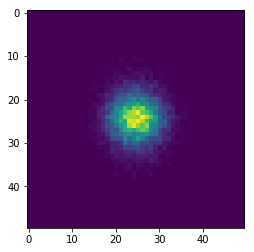

In [38]:
class InterpolatedPDF(object):

    def __init__(self, pdf, param_ranges):

        norm = np.max(pdf)
        self._pdf = pdf/norm
        
        nbins = np.shape(self._pdf)[0]
        points = []
        for prange in param_ranges:
            points.append(np.linspace(prange[0], prange[-1], nbins))
        self.param_ranges = param_ranges
        self.interp = RegularGridInterpolator(points, self._pdf)

    def sample(self, ndraw):
        
        """
        Sample the 2D distribution function with rejection sampling
        """
        points = np.empty((ndraw, 2))
        count = 0
        
        while count < ndraw:
            sample_dim_1 = np.random.uniform(self.param_ranges[0][0], self.param_ranges[0][1])
            sample_dim_2 = np.random.uniform(self.param_ranges[1][0], self.param_ranges[1][1])
            point = (sample_dim_1, sample_dim_2)
            prob = self.interp(point)
            if prob >= np.random.rand():
                points[count, 0], points[count, 1] = point[0], point[1]
                count += 1
        return points
    
    def sample_pdf(self, samples, nbins=50):
        """
        Rebin samples from the 2D distribution function
        """
        f_approx, _, _ = np.histogram2d(samples[:,0], samples[:,1], range=self.param_ranges, bins=nbins)
        return f_approx
        
f = distribution_function_no_perturbation.function
pranges = [[-2, 2], [-120, 120]]
interp_f = InterpolatedPDF(f, pranges)
n_samples = 10000
samples = interp_f.sample(n_samples)

z_positions, vz_samples = samples[:, 0], samples[:, 1]
f_approx = interp_f.sample_pdf(samples)

plt.figure(1)
plt.imshow(f_approx)

### Now initialize a bunch of test particles with values of (z, v_z) sampled from the unperturbed distribution function

In [40]:
class TestParticle(object):
    
    def __init__(self, z, vz):
        
        self.z = z
        self.vz = vz
        self.orbit = None
        self.orbit_with_satellite = None
        
test_particles = []
for i in range(0, len(z_positions)):
    test_particles.append(TestParticle(z_positions[i], vz_samples[i]))

## Integrate the orbit of each star in the combined moving satellite potential and the potential of the MW

In [43]:
# the total potential from satellite + Milky Way
satellite_moving_potential = MovingObjectPotential(satellite_orbit_list[0], satellite_potential, 
                                                   ro=units['ro'], vo=units['vo'])

total_potential = potential_extension.galactic_potential
total_vertical_potential = galpy.potential.toVerticalPotential(total_potential, 1., phi=0.)
galpy.potential.turn_physical_off(total_vertical_potential)

total_potential_with_satellite = satellite_moving_potential + potential_extension.galactic_potential
total_vertical_potential_with_satellite = galpy.potential.toVerticalPotential(total_potential_with_satellite, 1., phi=0.)
galpy.potential.turn_physical_off(total_vertical_potential_with_satellite)

for particle in test_particles:
    
    orb_no_satellite = Orbit([particle.z/units['ro'], particle.vz/units['vo']], ro=units['ro'], vo=units['vo'])
    orb_no_satellite.turn_physical_off()
    orb_no_satellite.integrate(time_internal_units, total_vertical_potential)
    particle.orbit = orb_no_satellite
    
    orb_with_satellite = Orbit([particle.z/units['ro'], particle.vz/units['vo']], ro=units['ro'], vo=units['vo'])
    orb_with_satellite.turn_physical_off()
    orb_with_satellite.integrate(time_internal_units, total_vertical_potential_with_satellite)
    particle.orbit_with_satellite = orb_with_satellite
   

In [ ]:
# the moving potential seems to have no effect on the orbit 
print(time_internal_units)
for particle in test_particles:
    plt.plot(particle.orbit.t, particle.orbit_with_satellite.x(time_internal_units) - particle.orbit.x(time_internal_units));
    plt.show()
    a=input('conitnue')

### Now rebin the test particles in order to compute the asymmetry and mean vertical velocity as a function of z
#### (We need to figure out why the moving potential seems to have no effect on the orbit; until then, everything below this part is sort of meaningless)

In [ ]:
z_final = np.array([star.orbit.x(0.) * units['ro'] for star in stars])
vz_final = np.array([star.orbit.vx(0.) * units['vo'] for star in stars])

# rebin
nbins = 51
nbins_half = 25
zbins = np.linspace(-2, 2, nbins)
vzbins = np.linspace(-20, 20, nbins)

mean_vertical_velocity = []
for i in range(0, len(zbins)-1):
    
    # select only stars in 
    cond1 = np.where(z_final > zbins[i])[0]
    cond2 = np.where(z_final <= zbins[i+1])[0]
    cond = np.logical_and(z_final > zbins[i], z_final <= zbins[i+1])
    inds = np.where(cond)
    mean_vz = np.mean(vz_final[inds])
    if np.isnan(mean_vz):
        mean_vz = 0.
    mean_vertical_velocity.append(mean_vz)
    
density, zbins = np.histogram(z_final, bins=zbins)
density_low, density_high = density[0:nbins_half][::-1], density[nbins_half:]
asymmetry = (density_high - density_low) / (density_low + density_high)

In [ ]:
plt.scatter(zbins[0::2][0:-1], asymmetry)

In [ ]:
mean_vertical_velocity_shifted = np.array(mean_vertical_velocity) - np.mean(mean_vertical_velocity)
plt.plot(zbins[0:-1], mean_vertical_velocity_shifted)

In [ ]:
# Now compute the action at each point in phase space (takes a long time)
compute_from_scratch = True
if compute_from_scratch:
    potential_extension = PotentialExtension(total_potential, zmax, vmax, phase_space_dim)
    f = open('potential_extension_test', 'wb')
    pickle.dump(potential_extension, f)
    f.close()
else:
    f = open('potential_extension_test', 'rb')
    potential_extension = pickle.load(f)
    f.close()

In [ ]:
midplane_density = potential_extension.rho_midplane
action = potential_extension.action
vertical_freq = potential_extension.vertical_freq
density_scale = util.bovy_conversion.dens_in_msolpc3(potential_extension.units['vo'], 
                                                     potential_extension.units['ro'])
velocity_scale = potential_extension.units['vo']
length_scale = potential_extension.units['ro']

df = DistributionFunction(rho_midplane=midplane_density, normalization_list=[1.],
                          velocity_dispersion_list=[20.5], J=action,
                          nu=vertical_freq, v_domain=v_units_internal, z_domain=z_units_internal, length_scale=1.,
                          velocity_scale=1., density_scale=1.)

In [ ]:
vz = df.mean_v_relative
plt.plot(vz)